## Quantum Lattice Boltzmann method

A few technical observations to begin with:

- for a function discretized on a regular mesh with N points, we need $log_2N$ qubits (for storing the information in a statevector).

* convetion: the leftmost qubit is the most significant 

### 1. The collision step

The collision step basically encodes the reorganization of the distribution functions upon the collision of the molecules in a particular lattice point. If we consider the medium to be sparse, we can neglect this step. And this is what we will next do for simplicity.

### 2. The streaming operation

This step is used to transmit the information from one lattice point to the other. We will model it as a permutation of qubits using multiple-control CNOT gates. The condition imposed here is periodical boundary conditions, a request caused by the fact that, at some point, the (say) rightmost lattice point will become the leftmost.

For example, if we want to move the parameters one step to the right - that is, for example, move the probability amplitude of 000000 to 000001, that of 000001 to 000010 etc, we would have to apply several multiple-control CNOT gates whose targets go from the most to least significant qubit. The circuit below is for the x-coordinate of the distribution function. The y-component is defined in a similar manner.

In [3]:
from qiskit import QuantumCircuit, QuantumRegister 
from qiskit import Aer, execute 
from qiskit.visualization import *
import matplotlib
print("Libraries imported successfully!")

Libraries imported successfully!


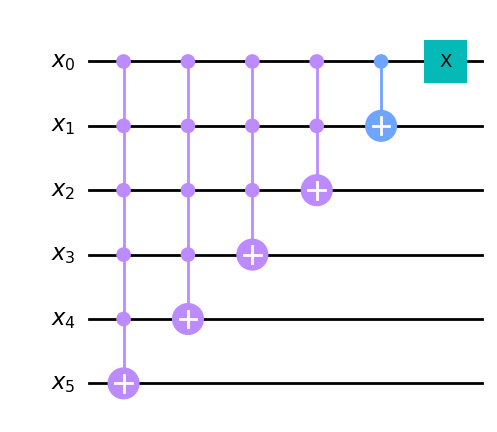

In [4]:
x = QuantumRegister(6, name='x')
qc = QuantumCircuit(x)
qc.mct([0,1,2,3,4], 5)
qc.mct([0,1,2,3], 4)
qc.mct([0,1,2], 3)
qc.mct([0,1], 2)
qc.cx(0, 1)
qc.x(0)

qc.draw(output='mpl')

 For the left streaming, everything we have to do is change the desired state of the control qubits from 1 to 0.

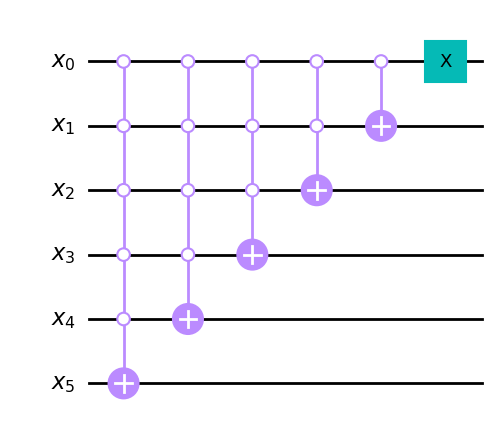

In [15]:
from qiskit.circuit.library import MCXGate
x = QuantumRegister(6, name='x')
qc = QuantumCircuit(x)
qc.append(MCXGate(5, ctrl_state="00000"), [0,1,2,3,4,5])
qc.append(MCXGate(4, ctrl_state="0000"), [0,1,2,3,4])
qc.append(MCXGate(3, ctrl_state="000"), [0,1,2,3])
qc.append(MCXGate(2, ctrl_state="00"), [0,1,2])
qc.cx(0, 1, ctrl_state="0")
qc.x(0)
qc.draw(output='mpl')

Furthermore, we have to take into account the fact the boundaries where the solid obstacle is placed. For this, a new qubit is introduced. For a given set of discrete velocities, which has the state 1000 in the positive direction and 0111 in the negative direction, the circuit implementation is how follows:

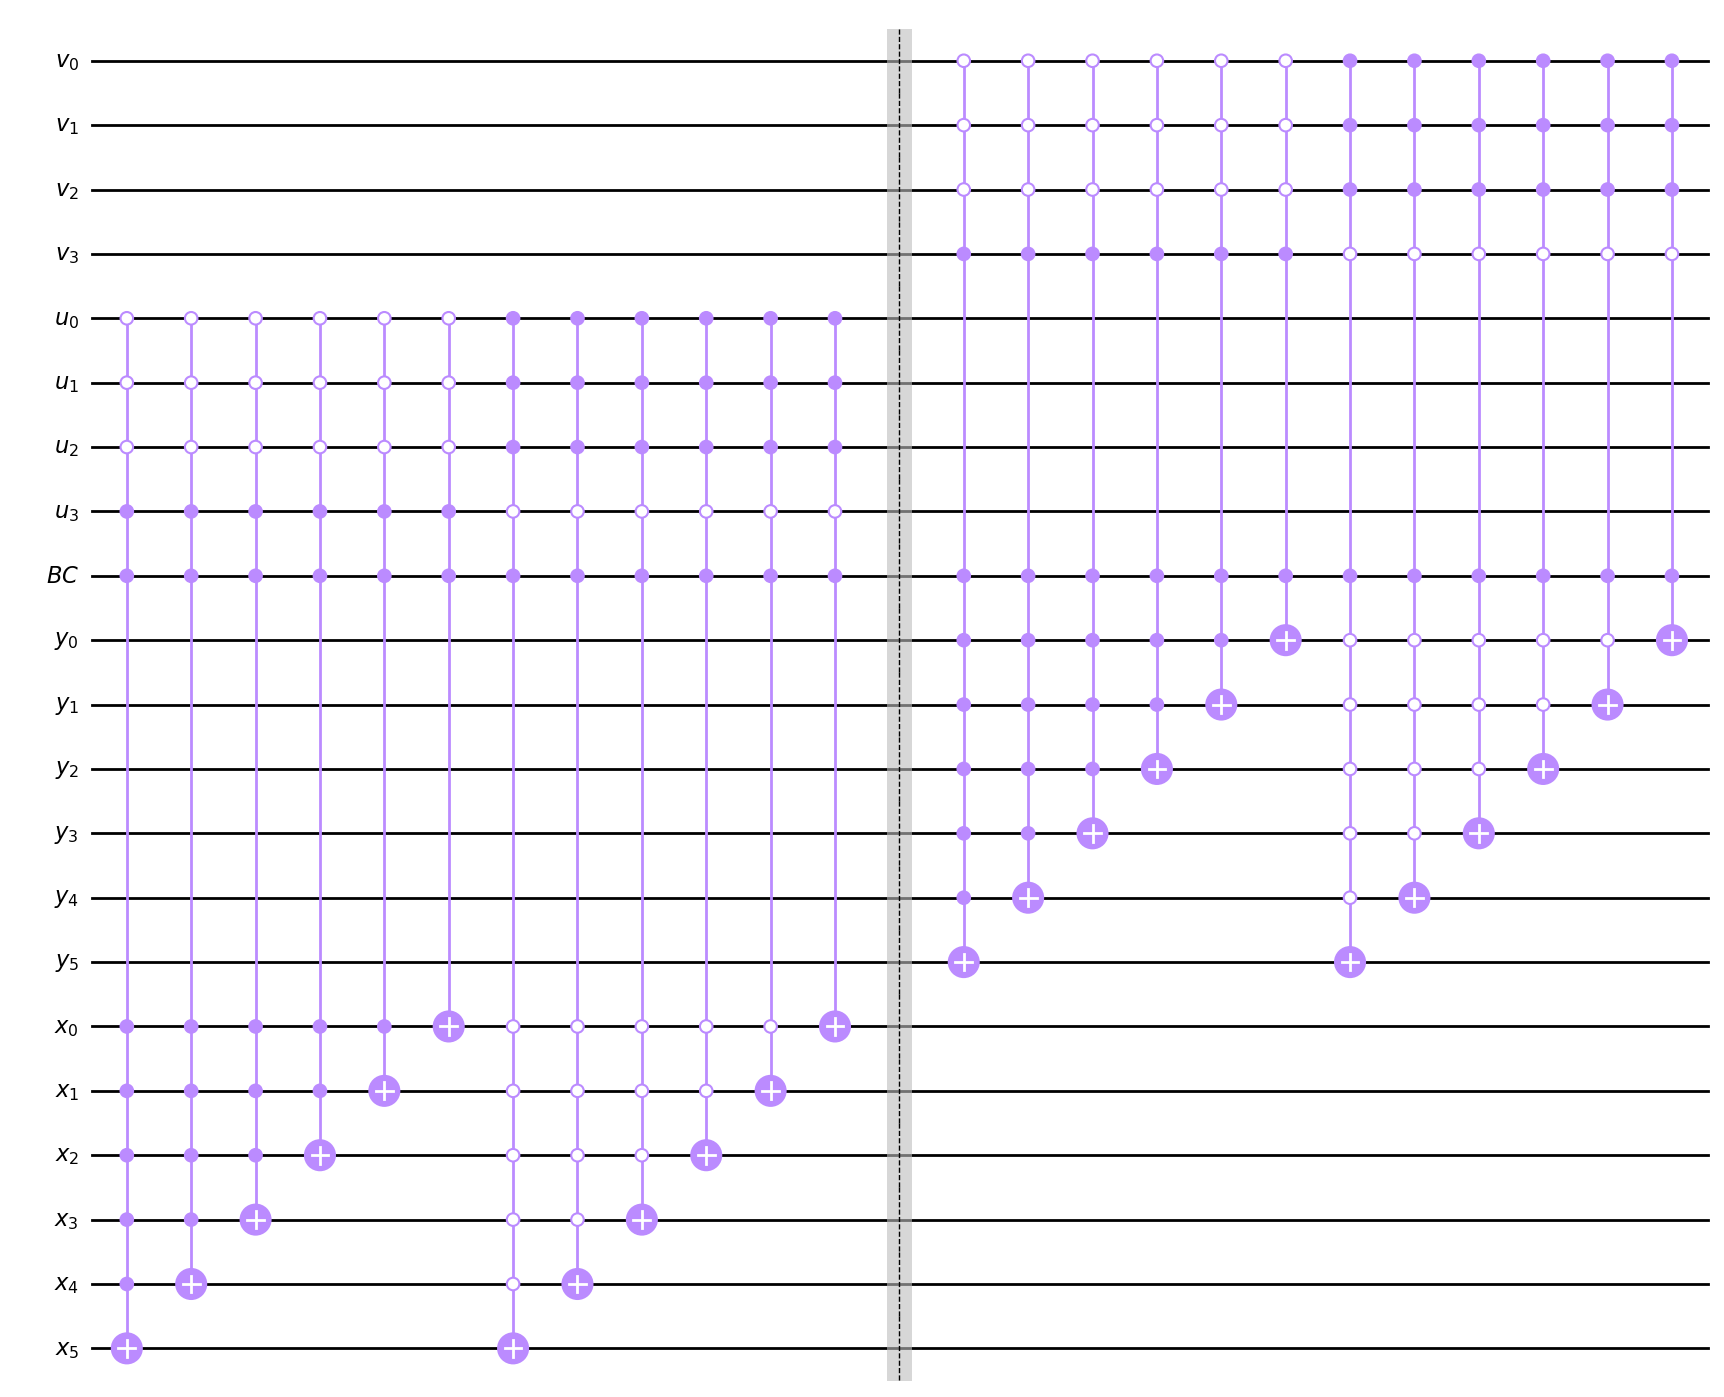

In [72]:
x = QuantumRegister(6, name='x')
y = QuantumRegister(6, name='y')
BC= QuantumRegister(1, name='BC')
u = QuantumRegister(4, name='u')
v = QuantumRegister(4, name='v')
qc = QuantumCircuit(v, u, BC, y, x)
qc.append(MCXGate(10, ctrl_state="1111111000"), [4, 5, 6, 7, 8, 15, 16, 17, 18, 19, 20])
qc.append(MCXGate(9, ctrl_state="111111000"), [4, 5, 6, 7, 8, 15, 16, 17, 18, 19])
qc.append(MCXGate(8, ctrl_state="11111000"), [4, 5, 6, 7, 8, 15, 16, 17, 18])
qc.append(MCXGate(7, ctrl_state="1111000"), [4, 5, 6, 7, 8, 15, 16, 17])
qc.append(MCXGate(6, ctrl_state="111000"), [4, 5, 6, 7, 8, 15, 16])
qc.append(MCXGate(5, ctrl_state="11000"), [4, 5, 6, 7, 8, 15])
qc.append(MCXGate(10, ctrl_state="0000010111"), [4, 5, 6, 7, 8, 15, 16, 17, 18, 19, 20])
qc.append(MCXGate(9, ctrl_state="000010111"), [4, 5, 6, 7, 8, 15, 16, 17, 18, 19])
qc.append(MCXGate(8, ctrl_state="00010111"), [4, 5, 6, 7, 8, 15, 16, 17, 18])
qc.append(MCXGate(7, ctrl_state="0010111"), [4, 5, 6, 7, 8, 15, 16, 17])
qc.append(MCXGate(6, ctrl_state="010111"), [4, 5, 6, 7, 8, 15, 16])
qc.append(MCXGate(5, ctrl_state="10111"), [4, 5, 6, 7, 8, 15])
qc.barrier()
qc.append(MCXGate(10, ctrl_state="1111111000"), [0,1,2,3,8,9,10,11,12,13,14])
qc.append(MCXGate(9, ctrl_state="111111000"), [0,1,2,3,8,9,10,11,12,13])
qc.append(MCXGate(8, ctrl_state="11111000"), [0,1,2,3,8,9,10,11,12])
qc.append(MCXGate(7, ctrl_state="1111000"), [0,1,2,3,8,9,10,11])
qc.append(MCXGate(6, ctrl_state="111000"), [0,1,2,3,8,9,10])
qc.append(MCXGate(5, ctrl_state="11000"), [0,1,2,3,8,9])
qc.append(MCXGate(10, ctrl_state="0000010111"), [0,1,2,3,8,9,10,11,12,13,14])
qc.append(MCXGate(9, ctrl_state="000010111"), [0,1,2,3,8,9,10,11,12,13])
qc.append(MCXGate(8, ctrl_state="00010111"), [0,1,2,3,8,9,10,11,12])
qc.append(MCXGate(7, ctrl_state="0010111"), [0,1,2,3,8,9,10,11])
qc.append(MCXGate(6, ctrl_state="010111"), [0,1,2,3,8,9,10])
qc.append(MCXGate(5, ctrl_state="10111"), [0,1,2,3,8,9])
qc.draw(output='mpl')


Now, we have to add some boundary conditions - that means that we have to invert the directions of the velocities when we reach the liquid-solid boundary.